In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

In [2]:
import os
import librosa
import gc
import ast
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torchaudio
import sys
import json
from datasets import load_dataset
from evaluate import load
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import torchaudio
import torch
from transformers import AutoFeatureExtractor
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer
os.environ["WANDB_DISABLED"] = "true"

import kagglehub
path = kagglehub.dataset_download("mohammedabdeldayem/the-fake-or-real-dataset")

2025-07-22 17:03:47.251793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753203827.426442      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753203827.480096      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset = load_dataset("audiofolder", data_dir = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm")

Resolving data files:   0%|          | 0/53868 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/10798 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/4634 [00:00<?, ?it/s]

Computing checksums:  45%|####4     | 24223/53868 [00:05<00:06, 4844.43it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
labels = dataset['train'].features['label'].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# Feature Extractor

In [8]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")
feature_extractor

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

# Preprocessing

In [5]:
max_duration = 5.0

def preprocess(sample):
    audio_arrays = [x["array"] for x in sample["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate = feature_extractor.sampling_rate,
        max_length = int(feature_extractor.sampling_rate * max_duration),
        truncation = True,
    )
    return inputs

In [8]:
encoded_dataset = dataset.map(preprocess, remove_columns = ['audio'], batched = True)
encoded_dataset

Map:   0%|          | 0/53868 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/feature_extraction_wav2vec2.py:98: RuntimeWarning: Mean of empty slice.
  normed_input_values = [(x - x.mean()) / np.sqrt(x.var() + 1e-7) for x in input_values]
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/feature_extraction_wav2vec2.py:98: RuntimeWarning: Degrees of freedom <= 0 for slice
  normed_input_values = [(x - x.mean()) / np.sqrt(x.var() + 1e-7) for x in input_values]
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Map:   0%|          | 0/10798 [00:00<?, ? examples/s]

Map:   0%|          | 0/4634 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values'],
        num_rows: 53868
    })
    validation: Dataset({
        features: ['label', 'input_values'],
        num_rows: 10798
    })
    test: Dataset({
        features: ['label', 'input_values'],
        num_rows: 4634
    })
})

# Define Wav2Vec

In [ ]:
Wav2Vec = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels = len(labels),
    label2id = label2id,
    id2label = id2label,
)

# Training Arguments

In [ ]:
arguments = TrainingArguments(
    f"wav2vec2-base-finetuned-ks",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 3e-5,
    per_device_train_batch_size = 32,
    gradient_accumulation_steps = 4,
    per_device_eval_batch_size = 32,
    num_train_epochs = 5,
    warmup_ratio = 0.1,
    logging_steps = 10,
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
    
)

In [9]:
metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis = 1)
    return metric.compute(predictions = predictions, references = eval_pred.label_ids)

# Training

In [ ]:
trainWav2Vec = Trainer(
    Wav2Vec,
    arguments,
    train_dataset = encoded_dataset['train'],
    eval_dataset = encoded_dataset['validation'],
    tokenizer = feature_extractor,
    compute_metrics = compute_metrics
)

In [ ]:
trainWav2Vec.train()

# Save Model

In [10]:
trainWav2Vec.save_model("/kaggle/working/Wav2Vec")
feature_extractor.save_pretrained("/kaggle/working/Wav2Vec")

# Visualization

In [127]:
with open("/kaggle/input/wav2vec2/other/default/1/wav2vec2-base-finetuned-ks/checkpoint-1055/trainer_state.json", "r") as f:
    trainer_state = json.load(f)
training_history = trainer_state["log_history"]

epochs, acc, loss = [], [], []
for i in training_history:
    if i["epoch"] % 1 == 0 or i["epoch"] % 2 == 0:
        epochs.append(i['epoch'])
        acc.append(i['eval_accuracy'])
        loss.append(i['eval_loss'])

history = dict()
history['epoch'] = epochs
history['eval_accuracy'] = acc
history['eval_loss'] = loss

In [144]:
def plotResults(history, model_name='Model'):
    metrics = ['eval_loss', 'eval_accuracy']
    epochs = range(1, len(history['epoch']) + 1)
    fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 5))
    if len(metrics) == 1:
        axes = [axes]
    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.plot(epochs, history[metric], label=f'Val {metric}', marker='o')
        ax.set_title(f'{metric} over Epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True)
    plt.suptitle(model_name, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


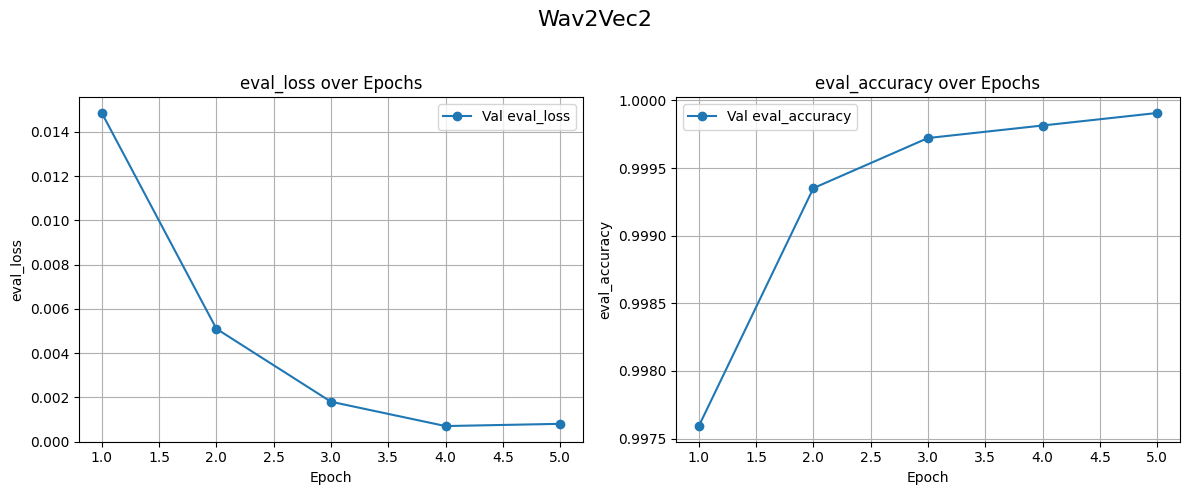

In [145]:
plotResults(history, model_name = 'Wav2Vec2')

# Load Model

In [7]:
feature_extractor = AutoFeatureExtractor.from_pretrained("/kaggle/input/wav2vec2/other/default/1/Wav2Vec")
Wav2Vec2 = AutoModelForAudioClassification.from_pretrained("/kaggle/input/wav2vec2/other/default/1/Wav2Vec")

# Evaluation

In [10]:
training_args = TrainingArguments(
    output_dir="/kaggle/input/wav2vec2/other/default/1/Wav2Vec",
    do_eval=True,
    per_device_eval_batch_size=8,
    logging_dir=None,
    report_to=[],
    logging_strategy="no",
)

trainer = Trainer(
    model=Wav2Vec2,
    args=training_args,
    eval_dataset = encoded_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_36/2454271009.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
results = trainer.evaluate()
print(f"Evaluation Loss: {results['eval_loss']}")
print(f"Evaluation Accuracy: {results['eval_accuracy']}")

Evaluation Loss: 3.582324504852295
Evaluation Accuracy: 0.5310746655157531


In [12]:
logits = trainer.predict(encoded_dataset["test"])
predicted = logits.predictions.argmax(axis = -1)
grouth_true = logits.label_ids

accuracy = metrics.accuracy_score(grouth_true, predicted)
precision = metrics.precision_score(grouth_true, predicted, average = 'weighted')
f1 = metrics.f1_score(grouth_true, predicted, average = 'weighted')
recall = metrics.recall_score(grouth_true, predicted, average = 'weighted')
roc_auc = metrics.roc_auc_score(grouth_true, predicted, average = 'weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1: {f1}")
print(f"Recall: {recall}")
print(f"ROC_AUC: {roc_auc}")

Accuracy: 0.5310746655157531
Precision: 0.7607286551110356
F1: 0.40863041049718796
Recall: 0.5310746655157531
ROC_AUC: 0.5415611814345991


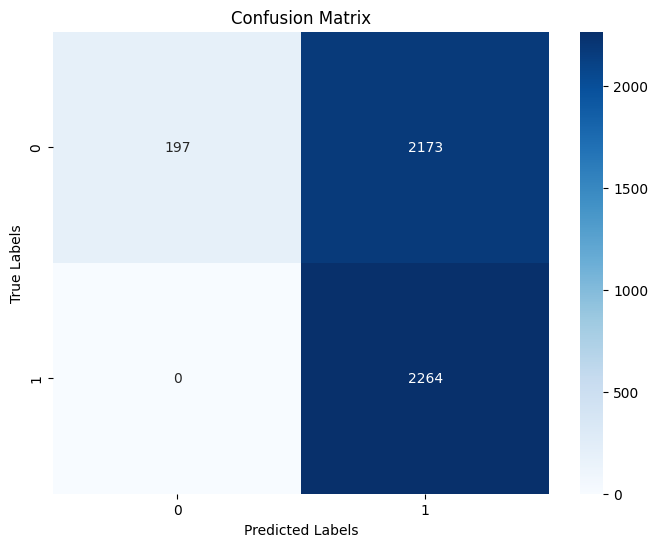

In [13]:
confusion_matrix = metrics.confusion_matrix(grouth_true, predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Inference

In [19]:
def inference(file_path, model, feature_extractor, label_mapper = None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    speech, sr = torchaudio.load(file_path)
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        speech = resampler(speech)

    inputs = feature_extractor(speech.squeeze().numpy(), sampling_rate = 16000, return_tensors = 'pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
        preds = torch.argmax(logits, dim = -1).item()

    if label_mapper:
        return f"Final prediction: {label_mapper(preds)}"
    return f"Final prediction: {preds}"

In [20]:
file_path = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
inference(file_path, Wav2Vec2, feature_extractor, encoded_dataset["train"].features["label"].int2str)

'Final prediction: real'